## partitioning structure in S3

    basepath: s3a://ungp-ais-data-historical-backup/comtrade/tariffline
    partition levels:
        
|level|field|values|
|---|---|---|
| 1st |typeCode| C for commodity, S for services| 
| 2nd |freqCode| A for annual, M for monthly |
| 3rd |reporterCode| integers representing each country |
| 4th |period| date in format yyyy for Annual or yyyymm for Monthly| 
        
Sample
1. Read monthly commodities data for all countries from 201901
    
```python
path = "s3a://ungp-ais-data-historical-backup/comtrade/tariffline/"
df=spark.read.option("basepath" = path) \
             .parquet(path + "/typeCode=C/freqCode=M/reporterCode=*/period=201901/*")
```

2. Read monthly commodities data for all countries from 201901 - 201903

```python
path = "s3a://ungp-ais-data-historical-backup/comtrade/tariffline/"
df=spark.read.option("basepath" = path) \
             .parquet([path + "typeCode=C/freqCode=M/reporterCode=*/period=201901/*",
                       path + "typeCode=C/freqCode=M/reporterCode=*/period=201902/*",
                       path + "typeCode=C/freqCode=M/reporterCode=*/period=201903/*"])
```

In [10]:
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType, TimestampType
import numpy as np

In [11]:
df=spark.read.parquet("s3a://ungp-ais-data-historical-backup/comtrade/tariffline/typeCode=C/freqCode=M/")

In [12]:
#alternative to read a much smaller dataset
# path = "s3a://ungp-ais-data-historical-backup/comtrade/tariffline/"
# paths = [path + "typeCode=C/freqCode=M/reporterCode=*/period=2018*", 
#          path + "typeCode=C/freqCode=M/reporterCode=*/period=2019*", 
#          path + "typeCode=C/freqCode=M/reporterCode=*/period=2020*", 
#          path + "typeCode=C/freqCode=M/reporterCode=*/period=2021*"] 

# df=spark.read.option("basepath",path).parquet(*paths)

In [13]:
df.printSchema()

root
 |-- datasetCode: long (nullable = true)
 |-- refPeriodId: integer (nullable = true)
 |-- flowCategory: string (nullable = true)
 |-- flowCode: string (nullable = true)
 |-- partnerCode: integer (nullable = true)
 |-- partner2Code: integer (nullable = true)
 |-- classificationCode: string (nullable = true)
 |-- cmdCode: string (nullable = true)
 |-- customsCode: string (nullable = true)
 |-- mosCode: integer (nullable = true)
 |-- motCode: integer (nullable = true)
 |-- qtyUnitCode: integer (nullable = true)
 |-- qty: double (nullable = true)
 |-- altQtyUnitCode: integer (nullable = true)
 |-- altQty: double (nullable = true)
 |-- netWgt: double (nullable = true)
 |-- grossWgt: double (nullable = true)
 |-- cifValue: double (nullable = true)
 |-- fobValue: double (nullable = true)
 |-- primaryValue: double (nullable = true)
 |-- reporterCode: integer (nullable = true)
 |-- period: integer (nullable = true)



In [14]:
#it's around 3 bil records for annual and monthly merchandise trade tariff line data
#skip this if not necessary
#df.count()

1959723416

In [15]:
#df.show()

In [16]:
#query string - show exports of "commodity code" in in 2018-01 - 2021-09 
Commodity_code = '3006' #pharmaceutical goods
Commodity_code = '2709' #crude oil
Commodity_code = '1006' #rice
Commodity_code = '6309' #secondhand/ worn clothing
Commodity_code = '7108' #non-monetary gold
Commodity_code = '0901' #coffee

SQLQueries = "select  motCode, cmdCode, period, flowCategory, primaryValue, netWgt, primaryValue/netWgt as UVnetWgt " \
          ", qtyUnitCode, qty, altQtyUnitCode, altQty from dfa " \
          "WHERE period between 201801 and 202109 and cmdCode like '" +Commodity_code+ "%' and flowCategory='X'"

In [17]:
#filter the data and convert to pandas - for easiness
df.createOrReplaceTempView("dfa")
pysparkDF = spark.sql(SQLQueries)
panDForig = pysparkDF.toPandas()

In [18]:
#convert period to string for better viz
panDForig['period'] = panDForig['period'].astype('string')
panDForig['motCode'] = panDForig['motCode'].astype('string')
print(panDForig.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299762 entries, 0 to 299761
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   motCode         299762 non-null  string 
 1   cmdCode         299762 non-null  object 
 2   period          299762 non-null  string 
 3   flowCategory    299762 non-null  object 
 4   primaryValue    299730 non-null  float64
 5   netWgt          293399 non-null  float64
 6   UVnetWgt        250540 non-null  float64
 7   qtyUnitCode     299762 non-null  int32  
 8   qty             299762 non-null  float64
 9   altQtyUnitCode  299762 non-null  int32  
 10  altQty          227485 non-null  float64
dtypes: float64(5), int32(2), object(2), string(2)
memory usage: 22.9+ MB
None


In [19]:
#show some records
panDForig.head()

,motCode,cmdCode,period,flowCategory,primaryValue,netWgt,UVnetWgt,qtyUnitCode,qty,altQtyUnitCode,altQty
0,3200,09012100,201905,X,371.552080,44.0,8.444365,8,44.0,8,44.0
1,3200,09011100,201905,X,221.454882,792.0,0.279615,8,792.0,8,792.0
2,3200,09011100,201905,X,6710.754000,1200.0,5.592295,8,1200.0,8,1200.0
3,3200,09011100,201905,X,1342.150800,240.0,5.592295,8,240.0,8,240.0
4,3200,09011100,201905,X,3366.561590,860.0,3.914607,8,860.0,8,860.0


In [20]:
#some descriptive stats
panDForig[['primaryValue','netWgt','UVnetWgt']].describe()

,primaryValue,netWgt,UVnetWgt
count,2.997300e+05,2.933990e+05,250540.000000
mean,3.240883e+05,8.419909e+04,52.323437
std,2.095854e+06,7.154595e+05,4017.448159
min,0.000000e+00,0.000000e+00,0.000000
25%,4.268923e+02,1.300000e+01,4.708830
50%,7.158931e+03,4.886000e+02,8.532727
75%,7.064251e+04,9.569245e+03,15.185792
max,1.384282e+08,4.141020e+07,842722.776940


Text(0.5, 1.0, 'Unit Value Distribution')

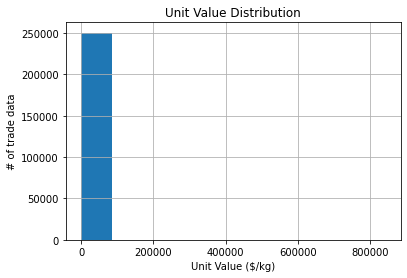

In [21]:
# This is what we want
panDForig.hist("UVnetWgt");
plt.xlabel('Unit Value ($/kg)')
plt.ylabel('# of trade data')
plt.title('Unit Value Distribution')
# But some have NaN and outliers

Text(0.5, 1.0, 'Unit Value Distribution')

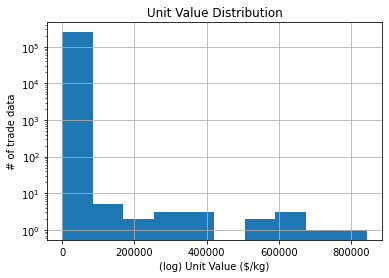

In [22]:
# This is what we want - in log scale (more suited for trade data with long distribution tail)
panDForig.hist("UVnetWgt", log=True);
plt.xlabel('(log) Unit Value ($/kg)')
plt.ylabel('# of trade data')
plt.title('Unit Value Distribution')
# But some have NaN and outliers

In [23]:
#remove UVnetWgt NaN and zero
panDF = panDForig[["motCode","period","UVnetWgt"]]
panDF = panDF[panDF.notnull()].query('UVnetWgt>0')
panDF.describe()
#print(panDF)

,UVnetWgt
count,2.504720e+05
mean,5.233764e+01
std,4.017993e+03
min,1.553390e-07
25%,4.711598e+00
50%,8.535103e+00
75%,1.518838e+01
max,8.427228e+05


In [24]:
#add log UVnetWgtLog
panDF.loc[:,'UVnetWgtLog'] = np.log(panDF['UVnetWgt'])
panDF.describe()

,UVnetWgt,UVnetWgtLog
count,2.504720e+05,250472.000000
mean,5.233764e+01,2.122063
std,4.017993e+03,1.050599
min,1.553390e-07,-15.677656
25%,4.711598e+00,1.550027
50%,8.535103e+00,2.144187
75%,1.518838e+01,2.720531
max,8.427228e+05,13.644393


In [25]:
#remove outliers based on zcores (if more than 3 standard deviation)
from scipy.stats import zscore
#calculate z-scores of `df`
z_scores = zscore(panDF['UVnetWgtLog'], axis=0)
#print(z_scores)
abs_z_scores = np.abs(z_scores)
#print(abs_z_scores)
filtered_entries = (abs_z_scores < 3)
#print(filtered_entries)
new_panDF = panDF[filtered_entries]

In [26]:
#descriptive statistics before outliers removal
panDF.describe()

,UVnetWgt,UVnetWgtLog
count,2.504720e+05,250472.000000
mean,5.233764e+01,2.122063
std,4.017993e+03,1.050599
min,1.553390e-07,-15.677656
25%,4.711598e+00,1.550027
50%,8.535103e+00,2.144187
75%,1.518838e+01,2.720531
max,8.427228e+05,13.644393


array([[<AxesSubplot:title={'center':'UVnetWgt'}>,
        <AxesSubplot:title={'center':'UVnetWgtLog'}>]], dtype=object)

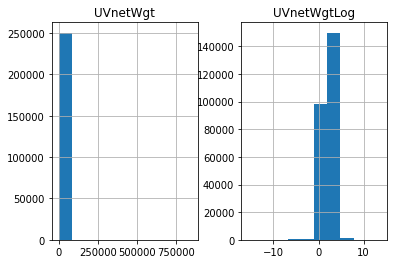

In [27]:
#histogram statistics before outliers removal
panDF.hist(column=['UVnetWgt','UVnetWgtLog'])

In [28]:
#descriptive statistics after outliers removal
new_panDF.describe()

,UVnetWgt,UVnetWgtLog
count,248259.000000,248259.000000
mean,12.799806,2.139226
std,14.439578,0.903285
min,0.357317,-1.029132
25%,4.760169,1.560283
50%,8.555295,2.146550
75%,15.139597,2.717314
max,195.161250,5.273826


array([[<AxesSubplot:title={'center':'UVnetWgt'}>,
        <AxesSubplot:title={'center':'UVnetWgtLog'}>]], dtype=object)

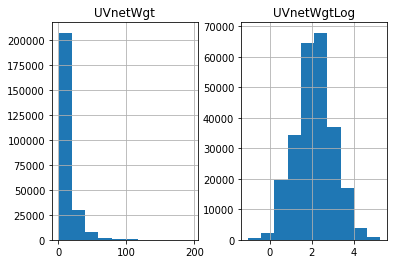

In [29]:
#histogram statistics after outliers removal
new_panDF.hist(column=['UVnetWgt','UVnetWgtLog'])

<AxesSubplot:xlabel='period'>

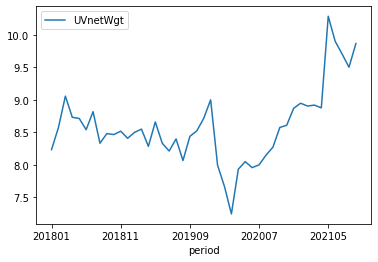

In [30]:
#plot median in timeseries before outliers removal
panDF[['period','UVnetWgt']].groupby("period").median().plot()

<AxesSubplot:xlabel='period'>

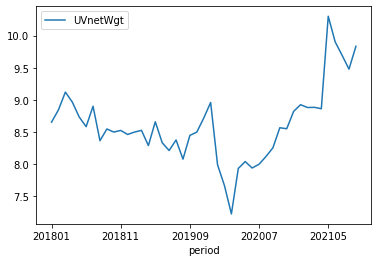

In [31]:
#plot median in timeseries after outliers removal
new_panDF[['period','UVnetWgt']].groupby("period").median().plot()

<AxesSubplot:xlabel='motCode'>

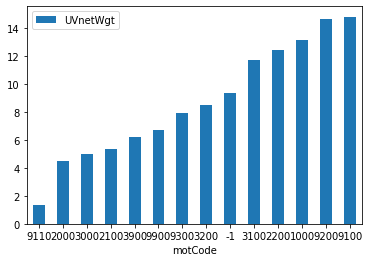

In [32]:
#plot median by mode of transport before outliers removal
panDF[['motCode','UVnetWgt']].groupby("motCode").median().sort_values(by='UVnetWgt').plot.bar(y='UVnetWgt', rot=0)

<AxesSubplot:xlabel='motCode'>

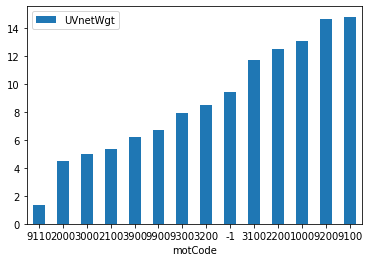

In [33]:
#plot median in mode of transport  after outliers removal
new_panDF[['motCode','UVnetWgt']].groupby("motCode").median().sort_values(by='UVnetWgt').plot.bar(y='UVnetWgt', rot=0)

In [34]:
#some extra analysis  - descriptive statstiscs by period
new_panDF[['period','UVnetWgt']].groupby("period").describe()

UVnetWgt                                                       \
          count       mean        std       min       25%        50%   
period                                                                 
201801   4757.0  12.873556  14.509500  0.357735  4.844096   8.654020   
201802   4910.0  13.345174  16.035370  0.370370  4.837019   8.845219   
201803   4949.0  12.766561  13.364446  0.373824  5.032334   9.121191   
201804   4791.0  12.832146  13.784669  0.374280  5.053716   8.966518   
201805   4832.0  12.380494  13.285493  0.360150  4.782349   8.733865   
201806   4642.0  12.644592  13.853775  0.381629  4.704969   8.583770   
201807   4770.0  12.592884  12.738618  0.360278  5.000260   8.901543   
201808   4746.0  12.048609  13.336379  0.375491  4.765555   8.365725   
201809   4974.0  12.404415  13.675620  0.363506  4.714572   8.547817   
201810   5427.0  12.412152  13.984492  0.368066  4.650986   8.500144   
201811   5550.0  12.619177  14.675383  0.363636  4.694431   8.525145   
201812   5228.0  12.526157  14.669580  0.362746  4.589919   8.462399   
201901   6190.0  12.744597  14.386147  0.358957  4.714977   8.499995   
201902   6048.0  12.352393  13.230645  0.357317  4.599304   8.526478   
201903   6247.0  12.337749  12.937744  0.363636  4.677869   8.290000   
201904   6169.0  12.605388  13.848553  0.377113  4.918209   8.659878   
201905   6402.0  12.321370  13.344059  0.360793  4.756058   8.333957   
201906   5968.0  12.535403  13.675704  0.383218  4.694290   8.212873   
201907   6407.0  12.367137  13.579834  0.431593  4.765610   8.377066   
201908   6401.0  11.719184  12.610256  0.410449  4.431390   8.079338   
201909   6366.0  12.683454  14.088505  0.365875  4.668397   8.448504   
201910   6805.0  12.425151  13.394920  0.374869  4.842095   8.498741   
201911   6503.0  12.569176  13.384036  0.368365  4.754620   8.717178   
201912   6649.0  12.938646  14.088148  0.370448  4.896141   8.959964   
202001   5684.0  11.960637  13.674381  0.400000  4.576314   7.990977   
202002   5705.0  11.774334  14.160483  0.363500  4.161138   7.666667   
202003   6061.0  11.182526  12.297174  0.390443  4.006815   7.227416   
202004   5101.0  11.937739  13.513384  0.375408  4.261508   7.934858   
202005   5385.0  12.211328  14.468248  0.398667  4.348712   8.041000   
202006   5655.0  12.525202  15.085385  0.411800  4.399858   7.941176   
202007   6062.0  12.404635  14.659710  0.384438  4.314668   8.000000   
202008   5509.0  12.457013  14.006813  0.370931  4.266616   8.120016   
202009   6116.0  12.775613  15.205515  0.433088  4.564438   8.254687   
202010   6242.0  13.027782  14.836077  0.399951  4.530946   8.567416   
202011   6204.0  13.305078  15.646736  0.381221  4.633663   8.551654   
202012   6072.0  13.752779  16.387334  0.371052  4.752484   8.821784   
202101   5317.0  13.916983  16.907550  0.362108  5.000000   8.925290   
202102   5482.0  13.879615  16.321875  0.366062  5.036105   8.881540   
202103   5647.0  13.714584  16.522646  0.453500  4.876689   8.884422   
202104   5364.0  13.723335  15.782369  0.444444  4.826772   8.862779   
202105   4432.0  14.614561  15.392980  0.383880  5.803487  10.300578   
202106   4715.0  14.750063  16.031470  0.520215  5.778819   9.902468   
202107   4647.0  14.731358  16.411793  0.443318  5.771592   9.693892   
202108   4324.0  14.078343  14.609794  0.418033  5.647962   9.478136   
202109   2804.0  14.947229  16.954779  0.509293  5.533328   9.832872   

                               
              75%         max  
period                         
201801  15.038736  183.039034  
201802  15.244339  194.206198  
201803  15.240802  166.424557  
201804  15.388772  166.431683  
201805  14.712387  162.702688  
201806  14.919898  172.000000  
201807  15.222927  166.326890  
201808  13.951910  169.557522  
201809  14.607328  163.221800  
201810  14.816898  195.161250  
201811  14.591478  178.032144  
201812  14.714112  193.000000  
201901  15.122129  190.047115  
201902  14.741213  152.797830  
201903

motCode	motName
-1	Not available or not specified.
0	All modes of transport
1000	Air
2000	Water
2100	Sea
2200	Inland waterway
2900	Water, not else classified
3000	Land
3100	Railway
3200	Road
3900	Land, not else classified
9000	Not elsewhere classified
9100	Pipelines and cables
9110	Pipelines
9120	Cables
9190	Pipelines and cables, not else classified
9200	Postal consignments, mail or courier shipment
9300	Self propelled goods
9900	Other


In [35]:
#some extra analysis - descriptive statstiscs by motOfTransport (air, water,land)
new_panDF[['motCode','UVnetWgt']].query('motCode in ("-1","1000","2000","3000")').groupby("motCode").describe()

UVnetWgt                                                       \
            count       mean        std       min       25%        50%   
motCode                                                                  
-1       110642.0  13.539567  14.459421  0.362108  5.623600   9.432421   
1000      15113.0  21.013590  23.791791  0.360793  7.474991  13.069105   
2000       4760.0   6.505970   4.911146  0.400000  3.291843   4.474984   
3000        862.0   5.098765   2.048954  0.904716  4.321353   4.990720   

                               
               75%        max  
motCode                        
-1       15.886094  195.06003  
1000     24.758775  195.16125  
2000      7.592365   60.90291  
3000      5.543611   44.21326

In [36]:
spark.stop()